<a href="https://www.kaggle.com/code/zer0ai/diabetes-classification-accuracy-knn-82-lr-77?scriptVersionId=161827709" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
dataset_path = '/kaggle/input/diabetes-dataset/diabetes.csv'
data = pd.read_csv(dataset_path)

print(data.columns)

# Display the first few rows of the dataset
data.head()


Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


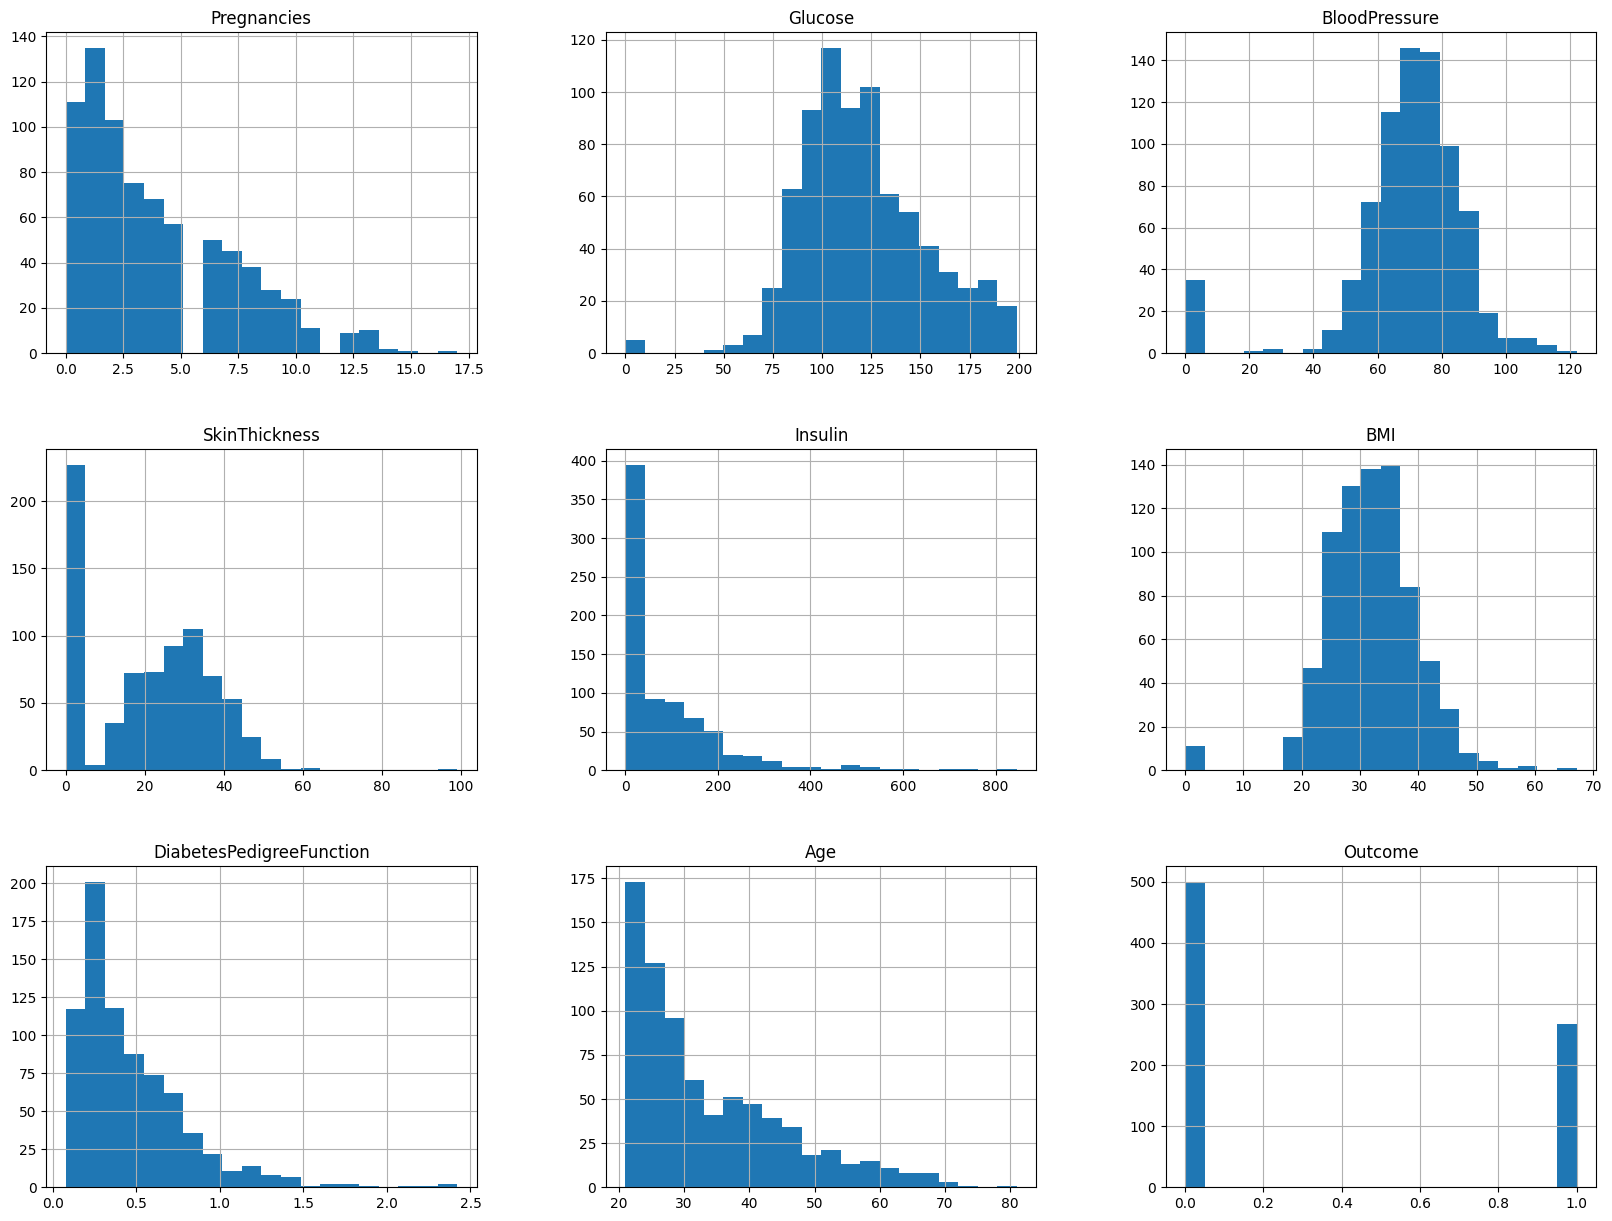

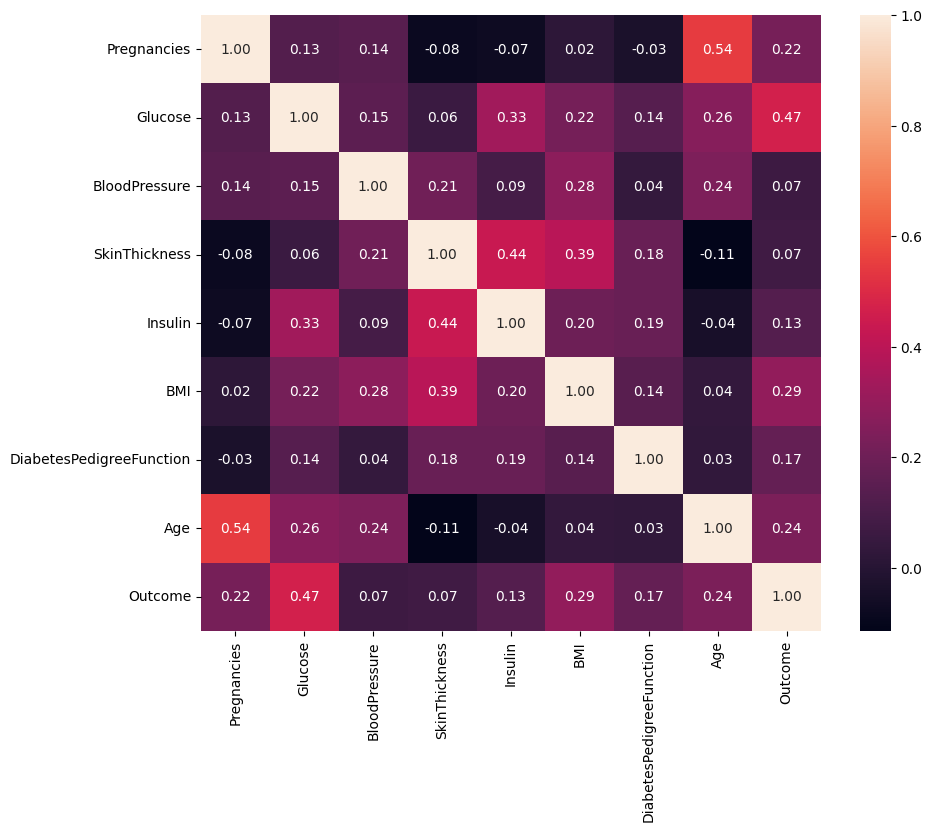

In [10]:
# Basic information about the dataset
data.info()

# Descriptive statistics
data.describe()

# Plotting distributions of numeric features
data.hist(bins=20, figsize=(20, 15))
plt.show()

# Correlation matrix
# Correlation matrix for numeric columns
numeric_columns = data.select_dtypes(include=[np.number])
corr_matrix = numeric_columns.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

## Train and evaluate 

In [11]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.preprocessing import StandardScaler

X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Normalizing the features
# For KNeighborsClassifier, normalizing features helps a lot because it ensures all features contribute equally to the distance calculation, improving model accuracy. 
# For LogisticRegression, normalization doesn't impact performance as much in this case but can still speed up training.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



def train_and_evaluate_model(model, name):
    print("Model: ", name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix:\n{conf_matrix}')

    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error (MAE):", mae)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error (MSE):", mse)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    
    print(classification_report(y_test, y_pred))
    
    print("----------------")
    return y_pred

y_pred = train_and_evaluate_model(LogisticRegression(), "LogisticRegression")


Model:  LogisticRegression
Accuracy: 0.7532467532467533
Confusion Matrix:
[[79 20]
 [18 37]]
Mean Absolute Error (MAE): 0.24675324675324675
Mean Squared Error (MSE): 0.24675324675324675
Root Mean Squared Error (RMSE): 0.496742636335202
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154

----------------



## The LogisticRegression model performs well, with an accuracy of 75%.

### Let's try the KNeighborsClassifier model next.

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score


y_pred = train_and_evaluate_model(KNeighborsClassifier(), "KNeighborsClassifier")

Model:  KNeighborsClassifier
Accuracy: 0.6883116883116883
Confusion Matrix:
[[79 20]
 [28 27]]
Mean Absolute Error (MAE): 0.3116883116883117
Mean Squared Error (MSE): 0.3116883116883117
Root Mean Squared Error (RMSE): 0.5582905262390825
              precision    recall  f1-score   support

           0       0.74      0.80      0.77        99
           1       0.57      0.49      0.53        55

    accuracy                           0.69       154
   macro avg       0.66      0.64      0.65       154
weighted avg       0.68      0.69      0.68       154

----------------


### As we can observe, the performance of the KNeighborsClassifier model isn't as strong as the LogisticRegression, achieving only 68% accuracy. This may be due to the n_neighbors parameter not being optimized. 
### Let's try finding and using the best n_neighbors value to potentially improve its performance.

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

def find_best_n_neighbors(): 
    # Setting up the parameter grid
    param_grid = {'n_neighbors': range(1, 100)} # the gri will try from 1 to 100 n_neighbors and return the best

    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')  # cv is the number of folds, scoring is the metric to evaluate
    grid_search.fit(X_train, y_train)

    best_n_neighbors = grid_search.best_params_['n_neighbors']
    return best_n_neighbors

best_n_neighbors = find_best_n_neighbors()
print("best_n_neighbors=", best_n_neighbors)

y_pred = train_and_evaluate_model(KNeighborsClassifier(n_neighbors=best_n_neighbors), "KNeighborsClassifier with best_n_neighbors")
train_and_evaluate_model(svm.SVC(kernel='linear'), "SVC")
svm.SVC(kernel='linear')

best_n_neighbors= 29
Model:  KNeighborsClassifier with best_n_neighbors
Accuracy: 0.7597402597402597
Confusion Matrix:
[[88 11]
 [26 29]]
Mean Absolute Error (MAE): 0.24025974025974026
Mean Squared Error (MSE): 0.24025974025974026
Root Mean Squared Error (RMSE): 0.4901629731627434
              precision    recall  f1-score   support

           0       0.77      0.89      0.83        99
           1       0.72      0.53      0.61        55

    accuracy                           0.76       154
   macro avg       0.75      0.71      0.72       154
weighted avg       0.76      0.76      0.75       154

----------------
Model:  SVC
Accuracy: 0.7597402597402597
Confusion Matrix:
[[81 18]
 [19 36]]
Mean Absolute Error (MAE): 0.24025974025974026
Mean Squared Error (MSE): 0.24025974025974026
Root Mean Squared Error (RMSE): 0.4901629731627434
              precision    recall  f1-score   support

           0       0.81      0.82      0.81        99
           1       0.67      0.65      0.66

SVC(kernel='linear')

## Great news! The optimal number of neighbors turned out to be 29, which boosted our accuracy from 68% to 75.9%. This means our model now performs a bit better than the Logistic Regression, which had an accuracy of 75.3%. However, the difference is so small that we can consider both models to perform similarly.

 Result accuracy:
- LogisticRegression - 0.7532467532467533
- KNeighborsClassifier - 0.7597402597402597

## When we look at the histogram for Outcome, it shows that the data is uneven. If we make the numbers more balanced, we might get improved results.

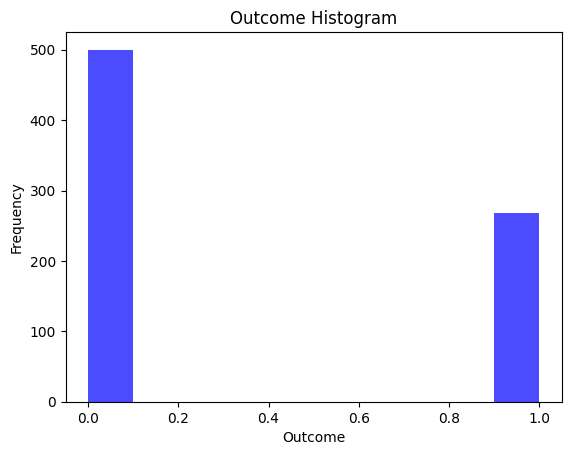

In [14]:
plt.hist(data['Outcome'], bins=10, alpha=0.7, color='blue')
plt.title('Outcome Histogram')
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.show()

In [15]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)



X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)


train_and_evaluate_model(LogisticRegression(), "LogisticRegression")

best_n_neighbors = find_best_n_neighbors()
train_and_evaluate_model(KNeighborsClassifier(n_neighbors=find_best_n_neighbors()), "KNeighborsClassifier")
print("best_n_neighbors=",best_n_neighbors)


import xgboost as xgb

train_and_evaluate_model(xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100), "XGBRegressor")


Model:  LogisticRegression
Accuracy: 0.7777777777777778
Confusion Matrix:
[[46 13]
 [11 38]]
Mean Absolute Error (MAE): 0.2222222222222222
Mean Squared Error (MSE): 0.2222222222222222
Root Mean Squared Error (RMSE): 0.4714045207910317
              precision    recall  f1-score   support

           0       0.81      0.78      0.79        59
           1       0.75      0.78      0.76        49

    accuracy                           0.78       108
   macro avg       0.78      0.78      0.78       108
weighted avg       0.78      0.78      0.78       108

----------------
Model:  KNeighborsClassifier
Accuracy: 0.8240740740740741
Confusion Matrix:
[[50  9]
 [10 39]]
Mean Absolute Error (MAE): 0.17592592592592593
Mean Squared Error (MSE): 0.17592592592592593
Root Mean Squared Error (RMSE): 0.41943524640393054
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        59
           1       0.81      0.80      0.80        49

    accuracy     

ValueError: Classification metrics can't handle a mix of binary and continuous targets

## It looks like the changes were successful. The accuracy of Logistic Regression improved from 75% to 77%, and the accuracy of K Neighbors Classifier increased from 75% to 82%.